In [1]:
import numpy as np
import torch.nn as nn
import torch
from tqdm import tqdm
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Visualize Datasets

In [3]:
def make_gaussian(batch_size):
    # Sample from a 2D standard Gaussian (mean=0, std=1)
    return torch.randn(batch_size, 2)

def make_checkerboard(batch_size):
    # Sample the x-coordinate uniformly in the range [-2, 2)
    x1 = torch.rand(batch_size) * 4 - 2

    # Sample the y-coordinate:
    # Step 1: draw from uniform [0, 1)
    # Step 2: subtract either 0 or 2, randomly (via torch.randint)
    # Result: values centered roughly around -2 or -1
    x2_ = torch.rand(batch_size) - torch.randint(high=2, size=(batch_size, )) * 2

    # Add a vertical shift depending on whether the x1 bin is even or odd
    # This creates the alternating row offset of the checkerboard
    x2 = x2_ + (torch.floor(x1) % 2)

    # Stack x1 and x2 into (batch_size, 2) vectors, and scale the whole grid
    data = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1) / 0.45

    return data.float()


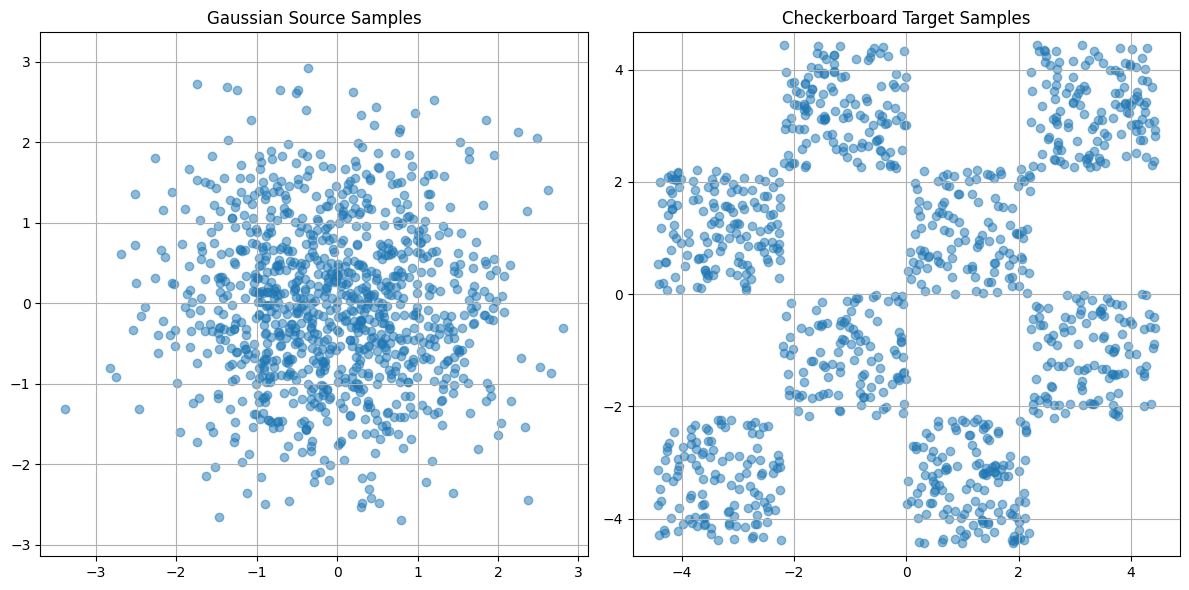

In [4]:
# Sample points
gaussian_samples = make_gaussian(1000)
checkerboard_samples = make_checkerboard(1000)

# Plot both
plt.figure(figsize=(12, 6))

# Plot Gaussian source
plt.subplot(1, 2, 1)
plt.scatter(gaussian_samples[:, 0], gaussian_samples[:, 1], alpha=0.5)
plt.title("Gaussian Source Samples")
plt.axis("equal")
plt.grid(True)

# Plot Checkerboard target
plt.subplot(1, 2, 2)
plt.scatter(checkerboard_samples[:, 0], checkerboard_samples[:, 1], alpha=0.5)
plt.title("Checkerboard Target Samples")
plt.axis("equal")
plt.grid(True)

plt.tight_layout()
plt.show()

# Neural Network

In [5]:
class FlowModel(nn.Module):  # Neural network to learn the time-dependent velocity field f(x, t)
  def __init__(self, input_dim=2, time_embed_dim=64):
    super().__init__()

    # Small MLP to embed the time scalar t into a higher-dimensional space
    self.time_embed = nn.Sequential(
        nn.Linear(1, time_embed_dim),
        nn.SiLU(),                     # Activation function: Sigmoid Linear Unit
        nn.Linear(time_embed_dim, time_embed_dim)
    )

    # Main network to predict velocity, given (x, embedded t)
    self.net = nn.Sequential(
        nn.Linear(input_dim + time_embed_dim, 128),  # Input: concatenated x and t embedding
        nn.SiLU(),
        nn.Linear(128, 128),
        nn.SiLU(),
        nn.Linear(128, 128),
        nn.SiLU(),
        nn.Linear(128, 128),
        nn.SiLU(),
        nn.Linear(128, 128),
        nn.SiLU(),
        nn.Linear(128, 128),
        nn.SiLU(),
        nn.Linear(128, input_dim)  # Output: predicted velocity (same dimension as x)
    )

  def forward(self, x, t):
    # Embed time t (shape: [batch_size, 1]) into a higher-dimensional vector
    t_embed = self.time_embed(t)

    # Concatenate position x and time embedding along the last dimension
    xt = torch.cat([x, t_embed], dim=-1)

    # Pass through the network to predict the velocity at (x, t)
    return self.net(xt)

# Flow Matching Loss

In [6]:
def flow_matching_loss(model, x0, x1, t):
  # Compute the interpolated point along the trajectory for each t
  xt = (1 - t) * x0 + t * x1

  # Compute the ground truth velocity vector (constant across trajectory)
  v_target = x1 - x0

  # Predict the velocity at point (x(t), t) using the model
  v_pred = model(xt, t)

  # Compute squared error between predicted and true velocity at each sample
  # Then average over the entire batch
  return ((v_pred - v_target) ** 2).mean()

# Sample Target + Source

In [7]:
def sample_target(batch_size):
    # Sample the x-coordinate uniformly in the range [-2, 2)
    x1 = torch.rand(batch_size) * 4 - 2

    # Sample the y-coordinate:
    # Step 1: draw from uniform [0, 1)
    # Step 2: subtract either 0 or 2, randomly (via torch.randint)
    # Result: values centered roughly around -2 or -1
    x2_ = torch.rand(batch_size) - torch.randint(high=2, size=(batch_size, )) * 2

    # Add a vertical shift depending on whether the x1 bin is even or odd
    # This creates the alternating row offset of the checkerboard
    x2 = x2_ + (torch.floor(x1) % 2)

    # Stack x1 and x2 into (batch_size, 2) vectors, and scale the whole grid
    data = 1.0 * torch.cat([x1[:, None], x2[:, None]], dim=1) / 0.45

    return torch.tensor(data, dtype=torch.float32)

In [8]:
def sample_source(batch_size):
    # Sample from a 2D standard Gaussian (mean=0, std=1)
    return torch.randn(batch_size, 2)

# Training Loop

In [9]:
num_steps = 10000
batch_size = 512
losses = []

model = FlowModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

for step in tqdm(range(num_steps)):
  x0 = sample_source(batch_size).to(device)
  x1 = sample_target(batch_size).to(device)
  t = torch.rand(batch_size, 1).to(device)  # Random interpolation time ∈ [0, 1]

  loss = flow_matching_loss(model, x0, x1, t)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss.item())

  if step % 100 == 0:
    print(f"Step {step} | Loss: {loss.item():.4f}")

  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipython-input-7-3261737578.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=torch.float32)
  1%|          | 70/10000 [00:00<01:20, 123.48it/s]

Step 0 | Loss: 7.4378


  1%|▏         | 134/10000 [00:01<00:47, 205.66it/s]

Step 100 | Loss: 4.5386


  2%|▏         | 239/10000 [00:01<00:33, 292.02it/s]

Step 200 | Loss: 4.0949


  3%|▎         | 344/10000 [00:01<00:29, 324.37it/s]

Step 300 | Loss: 4.3836


  4%|▍         | 450/10000 [00:01<00:28, 332.89it/s]

Step 400 | Loss: 3.8185


  6%|▌         | 554/10000 [00:02<00:28, 336.48it/s]

Step 500 | Loss: 3.9449


  7%|▋         | 660/10000 [00:02<00:26, 346.05it/s]

Step 600 | Loss: 4.3636


  8%|▊         | 764/10000 [00:02<00:27, 337.33it/s]

Step 700 | Loss: 4.1747


  9%|▊         | 867/10000 [00:03<00:27, 333.70it/s]

Step 800 | Loss: 4.0715


  9%|▉         | 937/10000 [00:03<00:26, 340.47it/s]

Step 900 | Loss: 3.7435


 10%|█         | 1043/10000 [00:03<00:26, 341.76it/s]

Step 1000 | Loss: 3.6054


 12%|█▏        | 1150/10000 [00:04<00:25, 344.41it/s]

Step 1100 | Loss: 3.5955


 13%|█▎        | 1254/10000 [00:04<00:26, 327.09it/s]

Step 1200 | Loss: 3.9767


 13%|█▎        | 1317/10000 [00:04<00:33, 260.35it/s]

Step 1300 | Loss: 3.8968


 15%|█▍        | 1454/10000 [00:05<00:33, 252.58it/s]

Step 1400 | Loss: 3.7464


 15%|█▌        | 1525/10000 [00:05<00:45, 188.31it/s]

Step 1500 | Loss: 3.8459


 16%|█▌        | 1614/10000 [00:06<00:41, 203.50it/s]

Step 1600 | Loss: 3.9172


 17%|█▋        | 1720/10000 [00:06<01:06, 125.04it/s]

Step 1700 | Loss: 3.6474


 18%|█▊        | 1827/10000 [00:07<00:58, 139.28it/s]

Step 1800 | Loss: 3.6869


 19%|█▉        | 1925/10000 [00:08<00:36, 219.64it/s]

Step 1900 | Loss: 3.7079


 20%|██        | 2027/10000 [00:08<00:33, 239.28it/s]

Step 2000 | Loss: 3.8460


 21%|██▏       | 2143/10000 [00:09<00:27, 280.69it/s]

Step 2100 | Loss: 4.0144


 22%|██▏       | 2244/10000 [00:09<00:24, 315.22it/s]

Step 2200 | Loss: 3.5203


 23%|██▎       | 2347/10000 [00:09<00:23, 330.39it/s]

Step 2300 | Loss: 4.2033


 25%|██▍       | 2453/10000 [00:10<00:22, 340.84it/s]

Step 2400 | Loss: 3.5886


 26%|██▌       | 2559/10000 [00:10<00:22, 333.43it/s]

Step 2500 | Loss: 3.8196


 27%|██▋       | 2665/10000 [00:10<00:21, 342.51it/s]

Step 2600 | Loss: 3.5670


 28%|██▊       | 2770/10000 [00:10<00:21, 343.69it/s]

Step 2700 | Loss: 4.1608


 28%|██▊       | 2840/10000 [00:11<00:20, 341.29it/s]

Step 2800 | Loss: 3.6221


 29%|██▉       | 2946/10000 [00:11<00:20, 340.70it/s]

Step 2900 | Loss: 4.0938


 31%|███       | 3052/10000 [00:11<00:20, 343.78it/s]

Step 3000 | Loss: 3.6566


 32%|███▏      | 3159/10000 [00:12<00:19, 343.71it/s]

Step 3100 | Loss: 3.8171


 33%|███▎      | 3265/10000 [00:12<00:20, 334.77it/s]

Step 3200 | Loss: 3.7409


 34%|███▎      | 3370/10000 [00:12<00:19, 340.01it/s]

Step 3300 | Loss: 3.7125


 34%|███▍      | 3441/10000 [00:12<00:19, 343.40it/s]

Step 3400 | Loss: 3.8107


 35%|███▌      | 3546/10000 [00:13<00:18, 344.28it/s]

Step 3500 | Loss: 3.8518


 37%|███▋      | 3651/10000 [00:13<00:18, 336.60it/s]

Step 3600 | Loss: 3.9955


 37%|███▋      | 3719/10000 [00:13<00:20, 305.09it/s]

Step 3700 | Loss: 3.8989


 38%|███▊      | 3838/10000 [00:14<00:22, 271.65it/s]

Step 3800 | Loss: 3.8764


 40%|███▉      | 3963/10000 [00:14<00:20, 300.59it/s]

Step 3900 | Loss: 3.9807


 41%|████      | 4065/10000 [00:14<00:18, 321.90it/s]

Step 4000 | Loss: 3.7696


 42%|████▏     | 4170/10000 [00:15<00:17, 338.58it/s]

Step 4100 | Loss: 3.8622


 42%|████▏     | 4241/10000 [00:15<00:16, 345.20it/s]

Step 4200 | Loss: 3.5328


 43%|████▎     | 4344/10000 [00:15<00:16, 334.20it/s]

Step 4300 | Loss: 3.7094


 44%|████▍     | 4449/10000 [00:16<00:16, 339.72it/s]

Step 4400 | Loss: 3.3785


 46%|████▌     | 4556/10000 [00:16<00:15, 347.05it/s]

Step 4500 | Loss: 4.0638


 47%|████▋     | 4662/10000 [00:16<00:15, 341.18it/s]

Step 4600 | Loss: 3.9454


 48%|████▊     | 4766/10000 [00:17<00:15, 330.68it/s]

Step 4700 | Loss: 3.7648


 49%|████▊     | 4872/10000 [00:17<00:14, 342.57it/s]

Step 4800 | Loss: 4.0048


 49%|████▉     | 4943/10000 [00:17<00:14, 348.06it/s]

Step 4900 | Loss: 3.6807


 50%|█████     | 5048/10000 [00:17<00:14, 337.86it/s]

Step 5000 | Loss: 3.4628


 52%|█████▏    | 5153/10000 [00:18<00:14, 343.29it/s]

Step 5100 | Loss: 3.9479


 53%|█████▎    | 5260/10000 [00:18<00:13, 349.22it/s]

Step 5200 | Loss: 3.9576


 54%|█████▎    | 5365/10000 [00:18<00:13, 336.30it/s]

Step 5300 | Loss: 3.6480


 54%|█████▍    | 5433/10000 [00:19<00:14, 319.44it/s]

Step 5400 | Loss: 3.8232


 56%|█████▌    | 5554/10000 [00:19<00:15, 280.94it/s]

Step 5500 | Loss: 3.7262


 56%|█████▋    | 5640/10000 [00:19<00:16, 272.46it/s]

Step 5600 | Loss: 3.6676


 58%|█████▊    | 5754/10000 [00:20<00:15, 271.18it/s]

Step 5700 | Loss: 3.8612


 58%|█████▊    | 5808/10000 [00:20<00:21, 198.74it/s]

Step 5800 | Loss: 3.6435


 59%|█████▉    | 5934/10000 [00:21<00:25, 157.82it/s]

Step 5900 | Loss: 3.8861


 60%|██████    | 6026/10000 [00:21<00:19, 198.94it/s]

Step 6000 | Loss: 3.8535


 61%|██████    | 6115/10000 [00:22<00:18, 206.29it/s]

Step 6100 | Loss: 3.5999


 62%|██████▏   | 6212/10000 [00:22<00:23, 159.19it/s]

Step 6200 | Loss: 3.7421


 63%|██████▎   | 6346/10000 [00:23<00:19, 190.14it/s]

Step 6300 | Loss: 3.6261


 64%|██████▍   | 6446/10000 [00:24<00:14, 246.88it/s]

Step 6400 | Loss: 3.6341


 65%|██████▌   | 6509/10000 [00:24<00:13, 265.46it/s]

Step 6500 | Loss: 3.8374


 66%|██████▌   | 6619/10000 [00:25<00:20, 165.18it/s]

Step 6600 | Loss: 3.7359


 68%|██████▊   | 6754/10000 [00:25<00:12, 264.16it/s]

Step 6700 | Loss: 3.9913


 69%|██████▊   | 6854/10000 [00:26<00:10, 303.01it/s]

Step 6800 | Loss: 3.7980


 70%|██████▉   | 6960/10000 [00:26<00:09, 333.68it/s]

Step 6900 | Loss: 3.9478


 71%|███████   | 7066/10000 [00:26<00:08, 342.87it/s]

Step 7000 | Loss: 3.7123


 71%|███████▏  | 7136/10000 [00:26<00:08, 342.81it/s]

Step 7100 | Loss: 3.7716


 72%|███████▏  | 7239/10000 [00:27<00:08, 334.70it/s]

Step 7200 | Loss: 3.7806


 73%|███████▎  | 7347/10000 [00:27<00:07, 348.49it/s]

Step 7300 | Loss: 3.6346


 75%|███████▍  | 7455/10000 [00:27<00:07, 347.87it/s]

Step 7400 | Loss: 3.4487


 76%|███████▌  | 7561/10000 [00:28<00:07, 337.32it/s]

Step 7500 | Loss: 3.8088


 77%|███████▋  | 7667/10000 [00:28<00:06, 344.00it/s]

Step 7600 | Loss: 3.5751


 77%|███████▋  | 7738/10000 [00:28<00:06, 344.94it/s]

Step 7700 | Loss: 3.7826


 78%|███████▊  | 7845/10000 [00:28<00:06, 347.36it/s]

Step 7800 | Loss: 3.8003


 79%|███████▉  | 7948/10000 [00:29<00:06, 335.01it/s]

Step 7900 | Loss: 3.9288


 81%|████████  | 8055/10000 [00:29<00:05, 344.38it/s]

Step 8000 | Loss: 4.0549


 82%|████████▏ | 8160/10000 [00:29<00:05, 342.27it/s]

Step 8100 | Loss: 3.7559


 83%|████████▎ | 8264/10000 [00:30<00:05, 332.12it/s]

Step 8200 | Loss: 3.3351


 84%|████████▎ | 8370/10000 [00:30<00:04, 344.70it/s]

Step 8300 | Loss: 4.2563


 84%|████████▍ | 8440/10000 [00:30<00:04, 342.22it/s]

Step 8400 | Loss: 3.6979


 85%|████████▌ | 8544/10000 [00:30<00:04, 337.81it/s]

Step 8500 | Loss: 3.5882


 86%|████████▋ | 8647/10000 [00:31<00:04, 332.87it/s]

Step 8600 | Loss: 3.7872


 87%|████████▋ | 8743/10000 [00:31<00:04, 277.94it/s]

Step 8700 | Loss: 4.1748


 89%|████████▊ | 8856/10000 [00:32<00:04, 272.21it/s]

Step 8800 | Loss: 3.7274


 89%|████████▉ | 8940/10000 [00:32<00:03, 267.87it/s]

Step 8900 | Loss: 3.7623


 90%|█████████ | 9027/10000 [00:32<00:03, 278.58it/s]

Step 9000 | Loss: 4.3621


 91%|█████████▏| 9136/10000 [00:33<00:03, 252.59it/s]

Step 9100 | Loss: 3.8126


 93%|█████████▎| 9256/10000 [00:33<00:02, 283.03it/s]

Step 9200 | Loss: 3.5228


 94%|█████████▎| 9358/10000 [00:33<00:02, 316.35it/s]

Step 9300 | Loss: 3.5598


 95%|█████████▍| 9464/10000 [00:34<00:01, 336.77it/s]

Step 9400 | Loss: 3.6839


 95%|█████████▌| 9533/10000 [00:34<00:01, 329.25it/s]

Step 9500 | Loss: 3.7131


 96%|█████████▋| 9640/10000 [00:34<00:01, 340.67it/s]

Step 9600 | Loss: 3.8033


 97%|█████████▋| 9747/10000 [00:35<00:00, 348.02it/s]

Step 9700 | Loss: 3.9063


 99%|█████████▊| 9851/10000 [00:35<00:00, 337.75it/s]

Step 9800 | Loss: 4.1771


100%|█████████▉| 9954/10000 [00:35<00:00, 334.18it/s]

Step 9900 | Loss: 3.6947


100%|██████████| 10000/10000 [00:35<00:00, 279.45it/s]


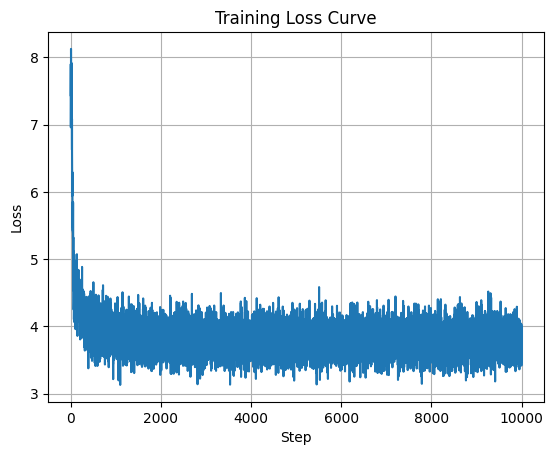

In [10]:
# Plot after training
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

In [11]:
def plot_velocity_row(model, t_values=[0.0, 0.25, 0.5, 0.75, 1.0], grid_size=20):
    model.eval()
    with torch.no_grad():
        # Set up grid and figure
        fig, axes = plt.subplots(1, len(t_values), figsize=(4 * len(t_values), 4))
        x = np.linspace(-4, 4, grid_size)
        y = np.linspace(-4, 4, grid_size)
        xx, yy = np.meshgrid(x, y)
        xy = np.stack([xx.flatten(), yy.flatten()], axis=1)
        xt = torch.tensor(xy, dtype=torch.float32).to(device)

        for i, t_val in enumerate(t_values):
            # Repeat t for each grid point
            tt = torch.full((xt.shape[0], 1), t_val, dtype=torch.float32).to(device)

            # Predict velocity vectors
            v = model(xt, tt).cpu().numpy()

            # Plot velocity field as arrows
            ax = axes[i]
            ax.quiver(xx, yy,
                      v[:, 0].reshape(grid_size, grid_size),
                      v[:, 1].reshape(grid_size, grid_size),
                      scale=20)
            ax.set_title(f"t = {t_val}")
            ax.axis("equal")
            ax.grid(True)

        plt.tight_layout()
        plt.show()

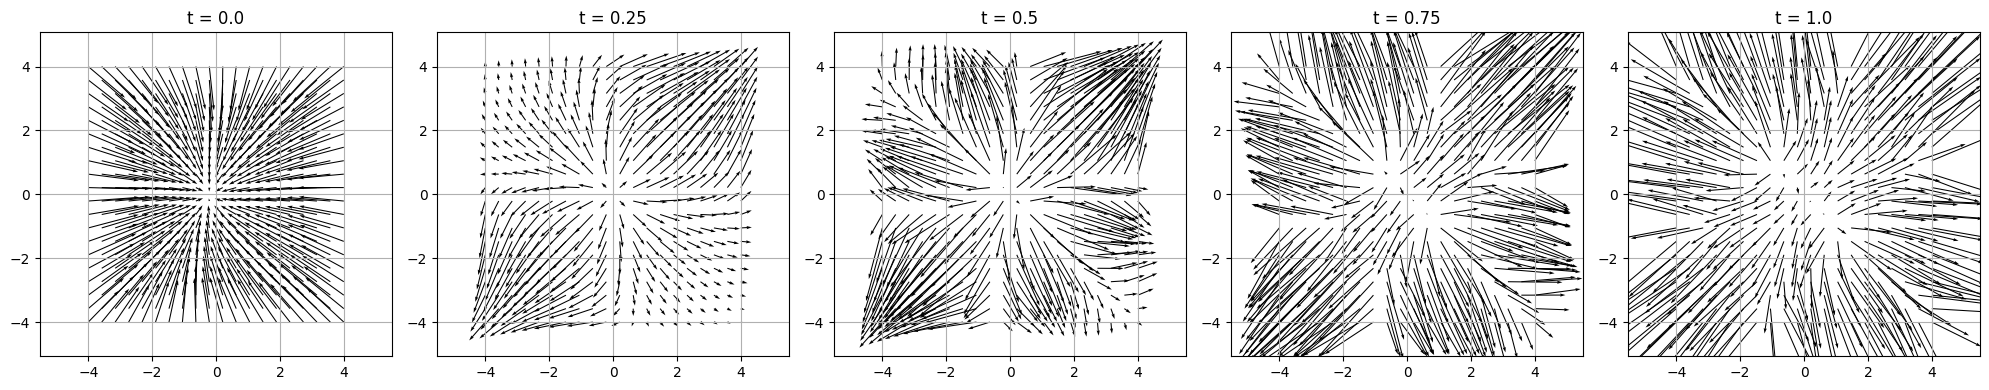

In [12]:
plot_velocity_row(model)

# Sampling (ODE Integration)

In [19]:
def sample_flow(model, x0, t_span=(0, 1)):
    """
    Evolve x0 through the learned flow to produce a sample from p1.
    """
    def ode_func(t, x):
        # Convert input x and time t into proper torch tensors
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
        t_tensor = torch.tensor([[t]], dtype=torch.float32).to(device)

        # Predict velocity without tracking gradients
        with torch.no_grad():
            v = model(x_tensor, t_tensor)

        # Return velocity as NumPy array (shape: [2])
        return v.squeeze(0).cpu().numpy()

    # Solve ODE from t=0 to t=1 using the learned velocity field
    sol = solve_ivp(ode_func, t_span, x0.cpu().numpy(), t_eval=[t_span[1]])

    # Return the final state at t=1 (i.e. predicted x1)
    return sol.y[:, -1]

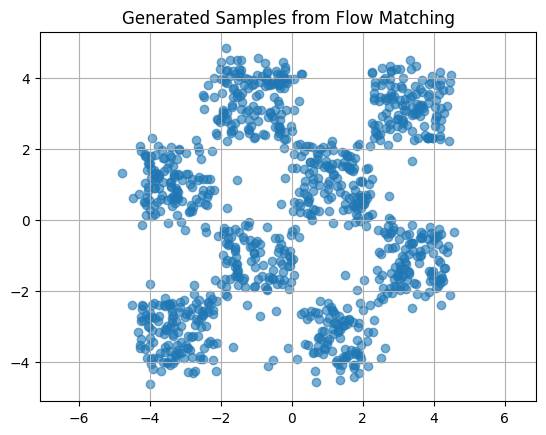

In [20]:
samples = []

# Sample 1000 points from the source distribution p₀
x0 = sample_source(1000).to(device)

# Push each point through the learned flow to generate a sample from p₁
for x in x0:
    with torch.no_grad():
        x = x.to(device)
        x1_hat = sample_flow(model, x, t_span=(0, 1))  # Integrate flow from t=0 to t=1
        samples.append(x1_hat)

# Convert list of sampled points to NumPy array for plotting
samples = np.array(samples)

# Scatter plot of generated samples in 2D
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6)
plt.title("Generated Samples from Flow Matching")
plt.axis("equal")
plt.grid(True)
plt.show()

/tmp/ipython-input-7-3261737578.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data, dtype=torch.float32)


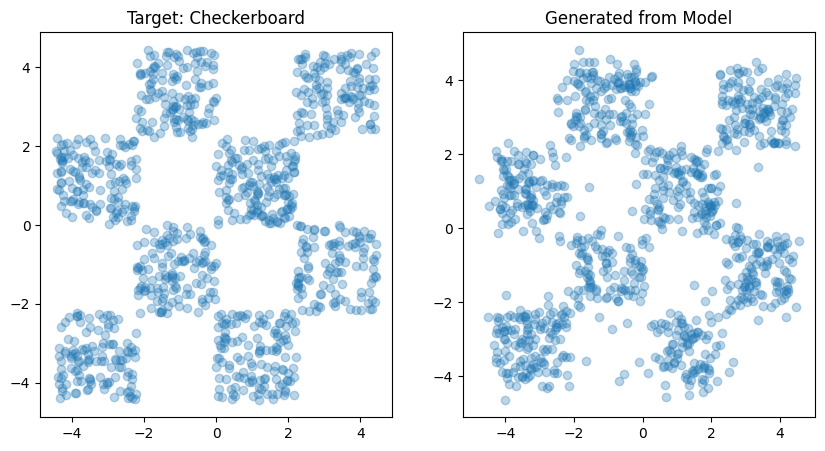

In [21]:
real = sample_target(1000)
gen = np.array(samples)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(real[:, 0], real[:, 1], alpha=0.3)
plt.title("Target: Checkerboard")

plt.subplot(1, 2, 2)
plt.scatter(gen[:, 0], gen[:, 1], alpha=0.3)
plt.title("Generated from Model")

plt.show()
